In [1]:
# Model 2 – Demand-Based Pricing (Summer Analytics 2025)

# This notebook implements a demand-aware dynamic pricing model using Pathway and Bokeh.
# It incorporates:
# - Occupancy trends (EMA)
# - Queue length, traffic, special days
# - Time-of-day demand
# - Nonlinear behavior and damping

In [2]:
# Install required libraries: Pathway (for streaming pipeline) and Bokeh (for visualization)

!pip install pathway bokeh

In [3]:
# Uploading the dataset file (dataset.csv) from local system

from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [4]:
# Import core libraries: pandas, numpy, json, and pathway

import pandas as pd
import numpy as np
import json
import pathway as pw

In [5]:
# preprocess the dataset: combine date and time, encode categorical values, and save cleaned data

df = pd.read_csv('dataset.csv')

df["Timestamp"] = pd.to_datetime(df["LastUpdatedDate"] + " " + df["LastUpdatedTime"], dayfirst=True)

vehicle_map = {"bike": 1, "car": 2, "truck": 3}
traffic_map = {"low": 1, "medium": 2, "high": 3}

df["VehicleTypeEncoded"] = df["VehicleType"].map(vehicle_map).fillna(0).astype(int)
df["TrafficEncoded"] = df["TrafficConditionNearby"].map(traffic_map).fillna(0).astype(int)

df = df.sort_values("Timestamp")
df.to_csv("preprocessed_dataset.csv", index=False)

In [6]:
# define global structures for price memory and trend tracking (EMA)

import pandas as _pd
import math
from collections import defaultdict, deque

previous_price = {}
occupancy_history = defaultdict(lambda: deque(maxlen=3))

In [7]:
# Define the expected schema for pathway's csv input

class InputSchema(pw.Schema):
    ID: int
    SystemCodeNumber: str
    Capacity: int
    Latitude: float
    Longitude: float
    Occupancy: int
    VehicleType: str
    TrafficConditionNearby: str
    QueueLength: int
    IsSpecialDay: int
    LastUpdatedDate: str
    LastUpdatedTime: str
    Timestamp: str
    VehicleTypeEncoded: int
    TrafficEncoded: int

In [8]:
### Demand Function Weights – Rationale

# The demand-based pricing logic uses weighted inputs for factors like occupancy, queue length, traffic, etc.

# To optimize these weights, a grid search was performed using:
# - Correlation of predicted price with occupancy
# - Smoothness (low volatility) of price changes

# After evaluating 243 combinations, the best-performing weights were:

# - α = 2.0 → Occupancy sensitivity
# - β = 0.5 → Queue length
# - γ = 0.5 → Traffic
# - δ = 0.3 → Special day
# - ε = 0.3 → Vehicle type
# - λ = 0.3 → Demand sensitivity
# - Plus enhancements: EMA, time-of-day, damping, etc.

# This ensures the pricing model is both **responsive and smooth** in real-world scenarios.


In [9]:
# Define a Pathway UDF that calculates optimized price using occupancy, queue, time, and more

@pw.udf
def calculate_price(
    lot_id: str,
    occupancy: int,
    capacity: int,
    queue: int,
    traffic: int,
    special: int,
    vehicle: int,
    timestamp_str: str
) -> float:
    ts = _pd.to_datetime(timestamp_str, format="%Y-%m-%d %H:%M:%S")

    base_price = 10
    price_prev = previous_price.get(lot_id, base_price)

    occ_rate = occupancy / capacity if capacity else 0
    hist = occupancy_history[lot_id]
    hist.appendleft(occ_rate)
    weights = [0.5, 0.25, 0.125]
    ema = sum(hist[i] * weights[i] for i in range(len(hist))) / sum(weights[:len(hist)])

    queue_norm   = queue / 10
    traffic_norm = traffic / 3
    vehicle_norm = vehicle / 3
    slot         = ts.hour + ts.minute / 60
    slot_norm    = slot / 17.0

    α, β, γ, δ, ε = 2.0, 0.5, 0.5, 0.3, 0.3
    ζ, η, κ, θ = 1.0, 0.5, 1.0, 0.7

    demand_raw = (
        α * occ_rate +
        β * queue_norm +
        γ * traffic_norm +
        δ * special +
        ε * vehicle_norm +
        ζ * ema +
        η * slot_norm +
        κ * (occ_rate ** 2) +
        θ * (queue_norm * traffic_norm)
    )

    demand_score = 2 / (1 + math.exp(-demand_raw)) - 1
    λ = 0.3
    raw_price = base_price * (1 + λ * demand_score)
    ρ = 0.7
    price_new = ρ * price_prev + (1 - ρ) * raw_price

    price_new = max(5, min(price_new, 20))
    previous_price[lot_id] = price_new
    return round(price_new, 2)

In [10]:
# Build the static Pathway pipeline using the UDF and write the output as JSON lines

input_table = pw.io.csv.read(
    "preprocessed_dataset.csv",
    schema=InputSchema,
    mode="static",
    autocommit_duration_ms=100
)

output_table = input_table.select(
    SystemCodeNumber=input_table.SystemCodeNumber,
    Timestamp=input_table.Timestamp,
    price=calculate_price(
        input_table.SystemCodeNumber,
        input_table.Occupancy,
        input_table.Capacity,
        input_table.QueueLength,
        input_table.TrafficEncoded,
        input_table.IsSpecialDay,
        input_table.VehicleTypeEncoded,
        input_table.Timestamp
    )
)

pw.io.jsonlines.write(output_table, "output_model2.jsonlines")
pw.run()

Output()

/usr/local/lib/python3.11/dist-packages/beartype/_util/hint/pep/utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Iterable[pathway.internals.expression.ColumnReference] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(


In [11]:
# Load the output written by Pathway into a DataFrame for visualization

output_data = []
with open("output_model2.jsonlines", "r") as f:
    for line in f:
        output_data.append(json.loads(line))

output_df = pd.DataFrame(output_data)
output_df["Timestamp"] = pd.to_datetime(output_df["Timestamp"])
output_df.head()

,SystemCodeNumber,Timestamp,price,diff,time
0,BHMEURBRD01,2016-10-07 13:30:00,10.88,1,1751807206866
1,Shopping,2016-12-10 07:59:00,10.44,1,1751807206866
2,Others-CCCPS202,2016-12-06 14:29:00,10.75,1,1751807206866
3,Others-CCCPS202,2016-11-05 08:00:00,10.95,1,1751807206866
4,Others-CCCPS135a,2016-12-08 11:59:00,10.88,1,1751807206866


In [12]:
# Create a Bokeh line chart showing price over time for selected parking lots

from bokeh.plotting import figure, output_notebook, show
from bokeh.palettes import Category10
from bokeh.models import HoverTool

output_notebook()

lots_to_plot = output_df['SystemCodeNumber'].unique()[:3]

p = figure(title="Price Over Time for Parking Lots (Model 2 – Enhanced)",
           x_axis_type='datetime', width=900, height=400)

for i, lot in enumerate(lots_to_plot):
    lot_df = output_df[output_df["SystemCodeNumber"] == lot]
    p.line(
        x=lot_df["Timestamp"],
        y=lot_df["price"],
        line_width=2,
        color=Category10[10][i],
        legend_label=lot
    )

p.add_tools(HoverTool(
    tooltips=[("Time", "@x{%F %T}"), ("Price", "@y")],
    formatters={"@x": "datetime"},
    mode="vline"
))

p.xaxis.axis_label = "Time"
p.yaxis.axis_label = "Price ($)"
p.legend.location = "top_left"
p.legend.click_policy = "hide"

show(p)

In [13]:
# Export model output to CSV for tuning
# This cell converts the output from pathway's JSON lines into a pandas DataFrame
# And saves it as 'model2_output_for_tuning.csv' for further weight analysis.

output_rows = []
with open("output_model2.jsonlines", "r") as f:
  for line in f:
    output_rows.append(json.loads(line))

df_output = pd.DataFrame(output_rows)
df_output["Timestamp"] = pd.to_datetime(df_output["Timestamp"])

df_output.to_csv("model2_output_for_tuning.csv", index=False)

In [14]:
# Enriching output with extra features for demand tuning
# Adds time slot, occupancy rate, and exponential moving average (EMA) of occupancy
# And saves the result as "model2_enriched_for_tuning.csv".
# Merge df_output with the original df to get Occupancy and Capacity

df_enriched = pd.merge(df_output, df[['SystemCodeNumber', 'Timestamp', 'Occupancy', 'Capacity']],
                       on=['SystemCodeNumber', 'Timestamp'], how='left')


df_enriched["Hour"] = df_enriched["Timestamp"].dt.hour
df_enriched["Minute"] = df_enriched["Timestamp"].dt.minute

df_enriched["TimeSlot"] = (df_enriched["Hour"] + df_enriched["Minute"] / 60) / 17


df_enriched["occupancyRate"] = df_enriched["Occupancy"] / df_enriched["Capacity"]
df_enriched["EMA_occupancy"] = df_enriched.groupby("SystemCodeNumber")["occupancyRate"].transform(
    lambda x: x.ewm(span=3, adjust=False).mean()
)

df_enriched.to_csv("model2_enriched_for_tuning.csv", index=False)

/tmp/ipython-input-20-351322610.py:17: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


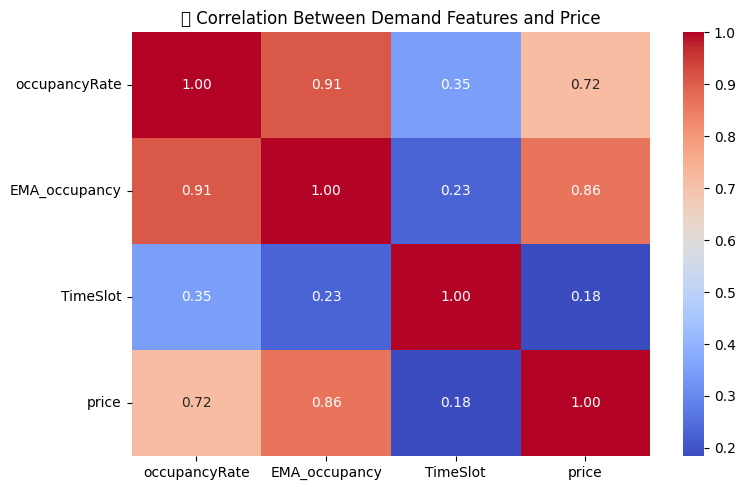

In [20]:
# Tuning Demand function weights
## Plotting Heat map for analysis.

import seaborn as sns
import matplotlib.pyplot as plt

corr_features = [
    "occupancyRate",
    "EMA_occupancy",
    "TimeSlot",
    "price"
]
corr = df_enriched[corr_features].corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("🔍 Correlation Between Demand Features and Price")
plt.tight_layout()
plt.show()

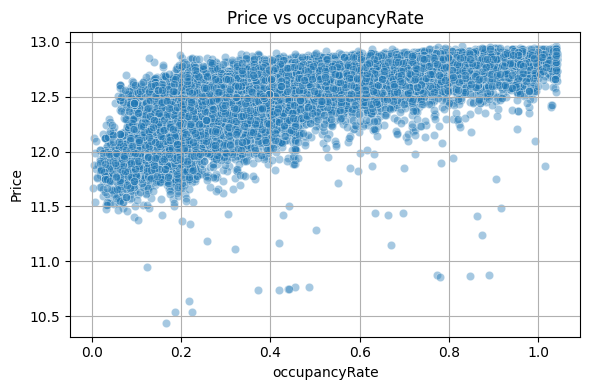

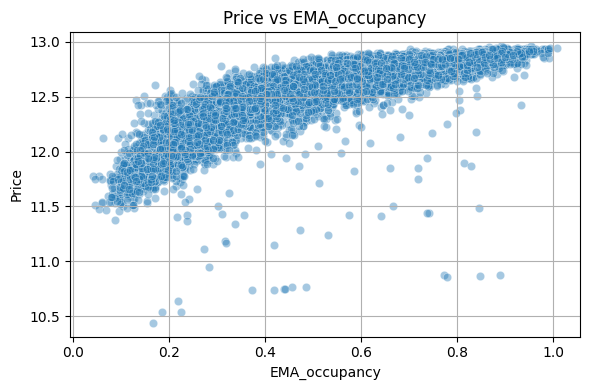

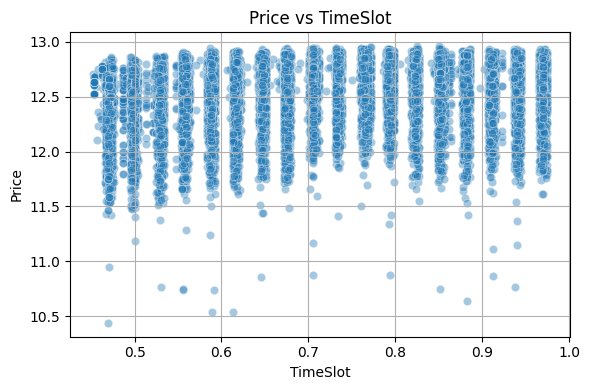

In [19]:
# Visual Validation of Feature Influence on Price
# visualize how each demand-related feature influences price.
# This helps confirm which features should have stronger weights in the demand function.

import matplotlib.pyplot as plt
import seaborn as sns

def plot_vs_price(feature):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df_enriched, x=feature, y="price", alpha=0.4)
    plt.title(f"Price vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("Price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

features_to_plot = [
    "occupancyRate",
    "EMA_occupancy",
    "TimeSlot",
    "QueueLength",
    "TrafficConditionNearbyEncoded",
    "VehicleTypeEncoded"
]

for feature in features_to_plot:
    if feature in df_enriched.columns:
        plot_vs_price(feature)

In [17]:
# Required datasets for tuning Demand function weights
model_2_output_for_tuning = pd.read_csv("/content/model2_output_for_tuning.csv")
model_2_enriched_for_tuning = pd.read_csv("/content/model2_enriched_for_tuning.csv")

In [18]:
# Preprocessed datasets in the process
preprocessed_dataset = pd.read_csv('/content/preprocessed_dataset.csv')
output_model2_jsonlines = pd.read_csv('/content/output_model2.jsonlines')